## **Question 3. Image Classification 3**

1. Download the CIFAR-10 dataset and load the pickled data into your program.

2. Build a basic CNN with several convolution blocks, where each block includes convolution, pooling, and normalization layers. Flatten the output and pass it through a dense layer that uses softmax activation. Evaluate the model on the validation set.

3. Replace the convolution blocks with Inception blocks and test the model's performance.

4. Replace the Inception blocks with residual blocks and test the model's performance.

5. Evaluate the algorithm and report results.

In [14]:
# Import necessary libraries
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import  transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the random seed
seed = 512
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## **Data Construction for Train**

Files already downloaded and verified
Files already downloaded and verified


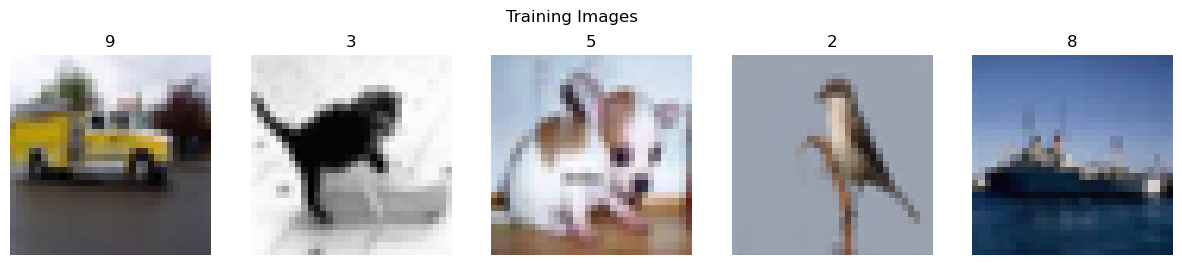

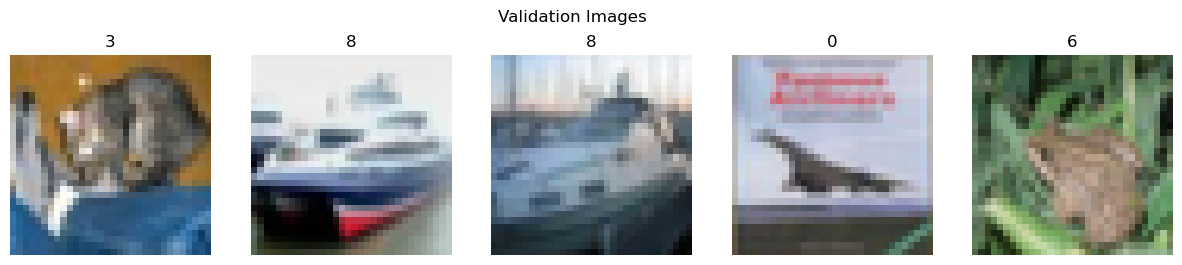

In [15]:
# Set transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# Download the CIFAR-10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./CIFAR-10', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR-10', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Function to display a batch of images from the DataLoader
def display_images(loader, title, num_images=5):
    images, labels = next(iter(loader))

    plt.figure(figsize=(15, 3))

    for i in range(num_images):
        # Get the i-th image and label from the batch
        image = images[i]
        label = labels[i].item()  # Convert label tensor to scalar

        # Rearrange the tensor dimensions from (C, H, W) to (H, W, C) for plotting
        image = image.permute(1, 2, 0).numpy()

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'{label}')

    plt.suptitle(title)
    plt.show()

# Display 5 random images from the training DataLoader
display_images(train_loader, "Training Images", num_images=5)

# Display 5 random images from the validation DataLoader
display_images(test_loader, "Validation Images", num_images=5)

## **Design Simple CNN Model**

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Batch normalization
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Batch normalization
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjusted for CIFAR-10 image size (32x32 pixels)
        self.fc2 = nn.Linear(512, 10)  # CIFAR-10 has 10 classes
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # First convolution layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second convolution layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third convolution layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the output
        x = x.view(-1, 128 * 4 * 4)
        
        # First fully connected layer 
        x = self.fc1(x)
        x = self.relu(x)
        
        # Second fully connected layer
        x = self.fc2(x)
        
        # Return the output with softmax activation
        return F.softmax(x, dim=1)


## **Design Simple CNN Model with Inception Blocks**

In [17]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        
        # 1x1 convolution branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Max pooling branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

    def forward(self, x):
        # Apply each branch and get the output
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        
        # Concatenate outputs from all branches
        outputs = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1)
        return outputs

# Simple CNN model using Inception Blocks
class SimpleCNNWithInception(nn.Module):
    def __init__(self):
        super(SimpleCNNWithInception, self).__init__()
        
        # First Inception block
        self.inception1 = InceptionBlock(in_channels=3)
        
        # Second Inception block
        self.inception2 = InceptionBlock(in_channels=128)
        
        # Third Inception block
        self.inception3 = InceptionBlock(in_channels=128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjusting for CIFAR-10 image size after pooling
        self.fc2 = nn.Linear(512, 10)           # CIFAR-10 has 10 classes
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # First Inception block
        x = self.inception1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second Inception block
        x = self.inception2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third Inception block
        x = self.inception3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the output
        x = x.view(-1, 128 * 4 * 4)
        
        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        
        # Second fully connected layer
        x = self.fc2(x)
        
        # Return the output with softmax activation
        return F.softmax(x, dim=1)


## **Design Simple CNN Model with Residual Blocks**

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 convolution to match input dimensions with output dimensions (when necessary)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
        # ReLU activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        input = x  # Save the input for the residual connection
        
        # First convolution layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # Second convolution layer
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Match input dimensions with output dimensions
        input = self.shortcut(input)
        
        # Add the input to the output (residual connection)
        x = x + input
        x = self.relu(x)
        
        return x

class SimpleCNNWithResidualBlocks(nn.Module):
    def __init__(self):
        super(SimpleCNNWithResidualBlocks, self).__init__()
        
        # First Residual Block
        self.residual1 = ResidualBlock(in_channels=3, out_channels=32)
        
        # Second Residual Block
        self.residual2 = ResidualBlock(in_channels=32, out_channels=64)
        
        # Third Residual Block
        self.residual3 = ResidualBlock(in_channels=64, out_channels=128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # ReLU activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # First residual block
        x = self.residual1(x)
        x = self.pool(x)
        
        # Second residual block
        x = self.residual2(x)
        x = self.pool(x)
        
        # Third residual block
        x = self.residual3(x)
        x = self.pool(x)
        
        # Flatten the output
        x = x.view(-1, 128 * 4 * 4)
        
        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        
        # Second fully connected layer
        x = self.fc2(x)
        
        # Return the output with softmax activation
        return F.softmax(x, dim=1)

## **Train and Evaluate Code**

In [19]:
# Function to train the model and track loss and accuracy during training
def train_evaluate_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device):
    train_losses = []     # List to store the training loss per epoch
    val_accuracies = []   # List to store the validation accuracy per epoch
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the cumulative loss during the epoch

        # Progress bar to show the training progress for each epoch
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients before each step
            outputs = model(inputs)  # Forward pass: compute the model output
            loss = criterion(outputs, labels)  # Compute the loss based on the model output and true labels
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update model parameters based on the gradients

            running_loss += loss.item()  # Accumulate the loss
            progress_bar.set_postfix(loss=running_loss / len(train_loader))  # Display the loss on the progress bar

        # Append the average loss for this epoch to the list
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluate the model on the validation set and store the validation accuracy
        val_accuracy = evaluate_model(model, val_loader, device)
        val_accuracies.append(val_accuracy)

    return train_losses, val_accuracies

# Function to evaluate the model's performance on the validation set
def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0   # Track the number of correct predictions
    total = 0     # Track the total number of predictions

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the selected device
            outputs = model(inputs)  # Forward pass: compute the model output
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class with the highest score
            total += labels.size(0)  # Update the total number of predictions
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    val_accuracy = 100 * correct / total  # Calculate the accuracy as a percentage
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    
    return val_accuracy

## **Set Parameters**

In [20]:
# Set the number of epochs and learning rate for training
num_epochs = 100
learning_rate = 0.001

# Check if GPU is available, otherwise use CPU for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

# Initialize a dictionary to store results for training and evaluation
results = {}

Using device: cuda


## **Train SimpleCNN**

In [21]:
# Initialize the Simple CNN model
model_simple_cnn = SimpleCNN().to(device)

# Define the Adam optimizer, using the model's parameters and the defined learning rate
optimizer_simple_cnn = optim.Adam(model_simple_cnn.parameters(), lr=learning_rate)

# Train the model and evaluate it on the validation set
print(f"{'*' * 20}Train Simple CNN{'*' * 20}")
train_losses_simple, val_accuracies_simple = train_evaluate_model(
    model_simple_cnn, 
    criterion, 
    optimizer_simple_cnn, 
    num_epochs, 
    train_loader,
    test_loader, 
    device
)

# Store the results (training losses and validation accuracies) in the results dictionary
results['Simple CNN'] = (train_losses_simple, val_accuracies_simple)

********************Train Simple CNN********************


Epoch 1/100: 100%|██████████| 391/391 [00:08<00:00, 44.22it/s, loss=2.04] 


Validation Accuracy: 48.60%


Epoch 2/100: 100%|██████████| 391/391 [00:08<00:00, 45.01it/s, loss=1.9]  


Validation Accuracy: 57.21%


Epoch 3/100: 100%|██████████| 391/391 [00:08<00:00, 45.86it/s, loss=1.85] 


Validation Accuracy: 58.51%


Epoch 4/100: 100%|██████████| 391/391 [00:08<00:00, 45.72it/s, loss=1.81] 


Validation Accuracy: 60.68%


Epoch 5/100: 100%|██████████| 391/391 [00:08<00:00, 45.63it/s, loss=1.79] 


Validation Accuracy: 62.09%


Epoch 6/100: 100%|██████████| 391/391 [00:08<00:00, 45.96it/s, loss=1.77] 


Validation Accuracy: 63.91%


Epoch 7/100: 100%|██████████| 391/391 [00:08<00:00, 45.65it/s, loss=1.76] 


Validation Accuracy: 65.81%


Epoch 8/100: 100%|██████████| 391/391 [00:08<00:00, 46.07it/s, loss=1.75] 


Validation Accuracy: 65.01%


Epoch 9/100: 100%|██████████| 391/391 [00:08<00:00, 45.74it/s, loss=1.74] 


Validation Accuracy: 67.51%


Epoch 10/100: 100%|██████████| 391/391 [00:08<00:00, 46.18it/s, loss=1.73] 


Validation Accuracy: 68.40%


Epoch 11/100: 100%|██████████| 391/391 [00:08<00:00, 45.88it/s, loss=1.72] 


Validation Accuracy: 70.56%


Epoch 12/100: 100%|██████████| 391/391 [00:08<00:00, 45.48it/s, loss=1.71] 


Validation Accuracy: 61.46%


Epoch 13/100: 100%|██████████| 391/391 [00:08<00:00, 45.42it/s, loss=1.7]  


Validation Accuracy: 70.94%


Epoch 14/100: 100%|██████████| 391/391 [00:08<00:00, 46.27it/s, loss=1.69] 


Validation Accuracy: 70.73%


Epoch 15/100: 100%|██████████| 391/391 [00:08<00:00, 45.92it/s, loss=1.69] 


Validation Accuracy: 71.27%


Epoch 16/100: 100%|██████████| 391/391 [00:08<00:00, 46.05it/s, loss=1.66] 


Validation Accuracy: 73.21%


Epoch 17/100: 100%|██████████| 391/391 [00:08<00:00, 45.90it/s, loss=1.64] 


Validation Accuracy: 69.43%


Epoch 18/100: 100%|██████████| 391/391 [00:08<00:00, 45.82it/s, loss=1.62] 


Validation Accuracy: 73.75%


Epoch 19/100: 100%|██████████| 391/391 [00:08<00:00, 45.96it/s, loss=1.62] 


Validation Accuracy: 69.70%


Epoch 20/100: 100%|██████████| 391/391 [00:08<00:00, 45.59it/s, loss=1.61] 


Validation Accuracy: 74.69%


Epoch 21/100: 100%|██████████| 391/391 [00:08<00:00, 45.77it/s, loss=1.6]  


Validation Accuracy: 76.09%


Epoch 22/100: 100%|██████████| 391/391 [00:08<00:00, 44.85it/s, loss=1.59] 


Validation Accuracy: 76.03%


Epoch 23/100: 100%|██████████| 391/391 [00:08<00:00, 44.76it/s, loss=1.58] 


Validation Accuracy: 76.59%


Epoch 24/100: 100%|██████████| 391/391 [00:08<00:00, 45.10it/s, loss=1.57] 


Validation Accuracy: 76.50%


Epoch 25/100: 100%|██████████| 391/391 [00:08<00:00, 44.76it/s, loss=1.57] 


Validation Accuracy: 75.07%


Epoch 26/100: 100%|██████████| 391/391 [00:08<00:00, 43.97it/s, loss=1.56] 


Validation Accuracy: 77.01%


Epoch 27/100: 100%|██████████| 391/391 [00:08<00:00, 43.47it/s, loss=1.55] 


Validation Accuracy: 76.65%


Epoch 28/100: 100%|██████████| 391/391 [00:10<00:00, 39.04it/s, loss=1.55] 


Validation Accuracy: 77.92%


Epoch 29/100: 100%|██████████| 391/391 [00:08<00:00, 45.79it/s, loss=1.55] 


Validation Accuracy: 79.12%


Epoch 30/100: 100%|██████████| 391/391 [00:08<00:00, 45.98it/s, loss=1.54] 


Validation Accuracy: 78.17%


Epoch 31/100: 100%|██████████| 391/391 [00:08<00:00, 45.98it/s, loss=1.54] 


Validation Accuracy: 77.31%


Epoch 32/100: 100%|██████████| 391/391 [00:08<00:00, 46.26it/s, loss=1.54] 


Validation Accuracy: 77.77%


Epoch 33/100: 100%|██████████| 391/391 [00:08<00:00, 45.70it/s, loss=1.54] 


Validation Accuracy: 76.97%


Epoch 34/100: 100%|██████████| 391/391 [00:08<00:00, 45.42it/s, loss=1.53] 


Validation Accuracy: 79.36%


Epoch 35/100: 100%|██████████| 391/391 [00:08<00:00, 46.06it/s, loss=1.53] 


Validation Accuracy: 78.43%


Epoch 36/100: 100%|██████████| 391/391 [00:08<00:00, 45.62it/s, loss=1.53] 


Validation Accuracy: 73.49%


Epoch 37/100: 100%|██████████| 391/391 [00:08<00:00, 46.30it/s, loss=1.53] 


Validation Accuracy: 78.38%


Epoch 38/100: 100%|██████████| 391/391 [00:08<00:00, 46.04it/s, loss=1.52] 


Validation Accuracy: 79.12%


Epoch 39/100: 100%|██████████| 391/391 [00:08<00:00, 45.79it/s, loss=1.53] 


Validation Accuracy: 78.58%


Epoch 40/100: 100%|██████████| 391/391 [00:08<00:00, 46.19it/s, loss=1.52] 


Validation Accuracy: 78.06%


Epoch 41/100: 100%|██████████| 391/391 [00:08<00:00, 45.31it/s, loss=1.52] 


Validation Accuracy: 76.38%


Epoch 42/100: 100%|██████████| 391/391 [00:08<00:00, 46.49it/s, loss=1.52] 


Validation Accuracy: 77.07%


Epoch 43/100: 100%|██████████| 391/391 [00:08<00:00, 45.93it/s, loss=1.52] 


Validation Accuracy: 79.61%


Epoch 44/100: 100%|██████████| 391/391 [00:08<00:00, 45.90it/s, loss=1.52] 


Validation Accuracy: 78.66%


Epoch 45/100: 100%|██████████| 391/391 [00:08<00:00, 46.14it/s, loss=1.52] 


Validation Accuracy: 78.73%


Epoch 46/100: 100%|██████████| 391/391 [00:08<00:00, 45.81it/s, loss=1.52] 


Validation Accuracy: 78.79%


Epoch 47/100: 100%|██████████| 391/391 [00:08<00:00, 46.08it/s, loss=1.51] 


Validation Accuracy: 78.83%


Epoch 48/100: 100%|██████████| 391/391 [00:08<00:00, 45.99it/s, loss=1.51] 


Validation Accuracy: 77.61%


Epoch 49/100: 100%|██████████| 391/391 [00:08<00:00, 46.06it/s, loss=1.51] 


Validation Accuracy: 73.23%


Epoch 50/100: 100%|██████████| 391/391 [00:08<00:00, 45.96it/s, loss=1.51] 


Validation Accuracy: 79.00%


Epoch 51/100: 100%|██████████| 391/391 [00:08<00:00, 45.88it/s, loss=1.51] 


Validation Accuracy: 78.15%


Epoch 52/100: 100%|██████████| 391/391 [00:08<00:00, 45.56it/s, loss=1.51] 


Validation Accuracy: 77.49%


Epoch 53/100: 100%|██████████| 391/391 [00:08<00:00, 46.58it/s, loss=1.51] 


Validation Accuracy: 78.55%


Epoch 54/100: 100%|██████████| 391/391 [00:08<00:00, 45.69it/s, loss=1.51] 


Validation Accuracy: 77.92%


Epoch 55/100: 100%|██████████| 391/391 [00:08<00:00, 46.22it/s, loss=1.51] 


Validation Accuracy: 79.41%


Epoch 56/100: 100%|██████████| 391/391 [00:08<00:00, 45.89it/s, loss=1.51] 


Validation Accuracy: 79.33%


Epoch 57/100: 100%|██████████| 391/391 [00:08<00:00, 45.85it/s, loss=1.51] 


Validation Accuracy: 77.86%


Epoch 58/100: 100%|██████████| 391/391 [00:08<00:00, 45.83it/s, loss=1.51] 


Validation Accuracy: 77.98%


Epoch 59/100: 100%|██████████| 391/391 [00:08<00:00, 45.72it/s, loss=1.51] 


Validation Accuracy: 78.78%


Epoch 60/100: 100%|██████████| 391/391 [00:08<00:00, 45.82it/s, loss=1.51] 


Validation Accuracy: 78.25%


Epoch 61/100: 100%|██████████| 391/391 [00:08<00:00, 45.72it/s, loss=1.51] 


Validation Accuracy: 78.81%


Epoch 62/100: 100%|██████████| 391/391 [00:08<00:00, 45.74it/s, loss=1.5]  


Validation Accuracy: 79.85%


Epoch 63/100: 100%|██████████| 391/391 [00:08<00:00, 45.91it/s, loss=1.5]  


Validation Accuracy: 78.09%


Epoch 64/100: 100%|██████████| 391/391 [00:08<00:00, 45.69it/s, loss=1.5]  


Validation Accuracy: 78.03%


Epoch 65/100: 100%|██████████| 391/391 [00:08<00:00, 45.60it/s, loss=1.5]  


Validation Accuracy: 79.63%


Epoch 66/100: 100%|██████████| 391/391 [00:08<00:00, 46.35it/s, loss=1.5]  


Validation Accuracy: 78.08%


Epoch 67/100: 100%|██████████| 391/391 [00:08<00:00, 45.70it/s, loss=1.51] 


Validation Accuracy: 77.44%


Epoch 68/100: 100%|██████████| 391/391 [00:08<00:00, 46.37it/s, loss=1.5]  


Validation Accuracy: 79.30%


Epoch 69/100: 100%|██████████| 391/391 [00:08<00:00, 45.56it/s, loss=1.5]  


Validation Accuracy: 79.37%


Epoch 70/100: 100%|██████████| 391/391 [00:08<00:00, 45.93it/s, loss=1.5]  


Validation Accuracy: 80.21%


Epoch 71/100: 100%|██████████| 391/391 [00:08<00:00, 46.09it/s, loss=1.5]  


Validation Accuracy: 77.94%


Epoch 72/100: 100%|██████████| 391/391 [00:08<00:00, 46.07it/s, loss=1.5]  


Validation Accuracy: 78.03%


Epoch 73/100: 100%|██████████| 391/391 [00:08<00:00, 46.22it/s, loss=1.5]  


Validation Accuracy: 79.52%


Epoch 74/100: 100%|██████████| 391/391 [00:08<00:00, 45.97it/s, loss=1.5]  


Validation Accuracy: 78.58%


Epoch 75/100: 100%|██████████| 391/391 [00:08<00:00, 46.19it/s, loss=1.5]  


Validation Accuracy: 77.26%


Epoch 76/100: 100%|██████████| 391/391 [00:08<00:00, 46.15it/s, loss=1.5]  


Validation Accuracy: 78.33%


Epoch 77/100: 100%|██████████| 391/391 [00:08<00:00, 45.91it/s, loss=1.5]  


Validation Accuracy: 79.53%


Epoch 78/100: 100%|██████████| 391/391 [00:08<00:00, 46.02it/s, loss=1.5]  


Validation Accuracy: 79.25%


Epoch 79/100: 100%|██████████| 391/391 [00:08<00:00, 46.06it/s, loss=1.5]  


Validation Accuracy: 78.20%


Epoch 80/100: 100%|██████████| 391/391 [00:08<00:00, 45.81it/s, loss=1.5]  


Validation Accuracy: 78.99%


Epoch 81/100: 100%|██████████| 391/391 [00:08<00:00, 46.27it/s, loss=1.5]  


Validation Accuracy: 79.08%


Epoch 82/100: 100%|██████████| 391/391 [00:08<00:00, 45.52it/s, loss=1.5]  


Validation Accuracy: 79.31%


Epoch 83/100: 100%|██████████| 391/391 [00:08<00:00, 46.40it/s, loss=1.5]  


Validation Accuracy: 78.86%


Epoch 84/100: 100%|██████████| 391/391 [00:08<00:00, 45.81it/s, loss=1.5]  


Validation Accuracy: 78.80%


Epoch 85/100: 100%|██████████| 391/391 [00:08<00:00, 45.71it/s, loss=1.5]  


Validation Accuracy: 78.82%


Epoch 86/100: 100%|██████████| 391/391 [00:08<00:00, 45.52it/s, loss=1.5]  


Validation Accuracy: 78.28%


Epoch 87/100: 100%|██████████| 391/391 [00:08<00:00, 45.53it/s, loss=1.5]  


Validation Accuracy: 79.70%


Epoch 88/100: 100%|██████████| 391/391 [00:08<00:00, 45.68it/s, loss=1.5]  


Validation Accuracy: 78.85%


Epoch 89/100: 100%|██████████| 391/391 [00:08<00:00, 45.88it/s, loss=1.5]  


Validation Accuracy: 78.98%


Epoch 90/100: 100%|██████████| 391/391 [00:08<00:00, 45.39it/s, loss=1.5]  


Validation Accuracy: 77.37%


Epoch 91/100: 100%|██████████| 391/391 [00:08<00:00, 44.85it/s, loss=1.5]  


Validation Accuracy: 77.42%


Epoch 92/100: 100%|██████████| 391/391 [00:08<00:00, 44.60it/s, loss=1.5]  


Validation Accuracy: 79.37%


Epoch 93/100: 100%|██████████| 391/391 [00:08<00:00, 44.54it/s, loss=1.5]  


Validation Accuracy: 79.46%


Epoch 94/100: 100%|██████████| 391/391 [00:08<00:00, 44.66it/s, loss=1.5]  


Validation Accuracy: 75.49%


Epoch 95/100: 100%|██████████| 391/391 [00:08<00:00, 44.51it/s, loss=1.5]  


Validation Accuracy: 77.45%


Epoch 96/100: 100%|██████████| 391/391 [00:08<00:00, 44.50it/s, loss=1.5]  


Validation Accuracy: 78.12%


Epoch 97/100: 100%|██████████| 391/391 [00:08<00:00, 44.73it/s, loss=1.5]  


Validation Accuracy: 79.14%


Epoch 98/100: 100%|██████████| 391/391 [00:08<00:00, 44.85it/s, loss=1.5]  


Validation Accuracy: 78.33%


Epoch 99/100: 100%|██████████| 391/391 [00:08<00:00, 44.47it/s, loss=1.5]  


Validation Accuracy: 78.83%


Epoch 100/100: 100%|██████████| 391/391 [00:08<00:00, 44.94it/s, loss=1.49] 


Validation Accuracy: 78.50%


## **Train SimpleCNN with Inception Blocks**

In [22]:
# Initialize the Simple CNN model with Inception Blocks
model_inception_blocks = SimpleCNNWithInception().to(device)

# Define the Adam optimizer, using the model's parameters and the defined learning rate
optimizer_inception_blocks = optim.Adam(model_inception_blocks.parameters(), lr=learning_rate)

# Train the model and evaluate it on the validation set
print(f"{'*' * 20}Train Simple CNN with Inception Blocks{'*' * 20}")
train_losses_inception_blocks, val_accuracies_inception_blocks = train_evaluate_model(
    model_inception_blocks, 
    criterion, 
    optimizer_inception_blocks, 
    num_epochs, 
    train_loader,
    test_loader,
    device
)

# Store the results (training losses and validation accuracies) in the results dictionary
results['CNN with Inception Blocks'] = (train_losses_inception_blocks, val_accuracies_inception_blocks)

********************Train Simple CNN with Inception Blocks********************


Epoch 1/100:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s, loss=2.01] 


Validation Accuracy: 49.85%


Epoch 2/100: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.89] 


Validation Accuracy: 56.95%


Epoch 3/100: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, loss=1.84] 


Validation Accuracy: 61.75%


Epoch 4/100: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, loss=1.81] 


Validation Accuracy: 64.14%


Epoch 5/100: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.79] 


Validation Accuracy: 61.60%


Epoch 6/100: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.77] 


Validation Accuracy: 64.09%


Epoch 7/100: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s, loss=1.76] 


Validation Accuracy: 68.17%


Epoch 8/100: 100%|██████████| 391/391 [00:19<00:00, 20.14it/s, loss=1.75] 


Validation Accuracy: 66.81%


Epoch 9/100: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s, loss=1.74] 


Validation Accuracy: 67.57%


Epoch 10/100: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s, loss=1.73] 


Validation Accuracy: 68.00%


Epoch 11/100: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, loss=1.72] 


Validation Accuracy: 69.12%


Epoch 12/100: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, loss=1.7]  


Validation Accuracy: 72.37%


Epoch 13/100: 100%|██████████| 391/391 [00:19<00:00, 19.90it/s, loss=1.68] 


Validation Accuracy: 70.87%


Epoch 14/100: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s, loss=1.66] 


Validation Accuracy: 75.78%


Epoch 15/100: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s, loss=1.64] 


Validation Accuracy: 72.90%


Epoch 16/100: 100%|██████████| 391/391 [00:19<00:00, 19.71it/s, loss=1.64] 


Validation Accuracy: 77.00%


Epoch 17/100: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s, loss=1.62] 


Validation Accuracy: 77.53%


Epoch 18/100: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s, loss=1.62] 


Validation Accuracy: 77.55%


Epoch 19/100: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s, loss=1.61] 


Validation Accuracy: 77.94%


Epoch 20/100: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s, loss=1.6]  


Validation Accuracy: 77.52%


Epoch 21/100: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s, loss=1.59] 


Validation Accuracy: 78.21%


Epoch 22/100: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s, loss=1.59] 


Validation Accuracy: 78.74%


Epoch 23/100: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s, loss=1.58] 


Validation Accuracy: 78.92%


Epoch 24/100: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s, loss=1.58] 


Validation Accuracy: 79.23%


Epoch 25/100: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s, loss=1.57] 


Validation Accuracy: 79.05%


Epoch 26/100: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s, loss=1.56] 


Validation Accuracy: 79.23%


Epoch 27/100: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s, loss=1.56] 


Validation Accuracy: 79.18%


Epoch 28/100: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s, loss=1.55] 


Validation Accuracy: 78.52%


Epoch 29/100: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s, loss=1.55] 


Validation Accuracy: 79.11%


Epoch 30/100: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s, loss=1.55] 


Validation Accuracy: 80.35%


Epoch 31/100: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s, loss=1.54] 


Validation Accuracy: 79.93%


Epoch 32/100: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s, loss=1.54] 


Validation Accuracy: 79.53%


Epoch 33/100: 100%|██████████| 391/391 [00:19<00:00, 19.92it/s, loss=1.54] 


Validation Accuracy: 77.89%


Epoch 34/100: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s, loss=1.54] 


Validation Accuracy: 79.93%


Epoch 35/100: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, loss=1.53] 


Validation Accuracy: 80.04%


Epoch 36/100: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s, loss=1.53] 


Validation Accuracy: 80.77%


Epoch 37/100: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.53] 


Validation Accuracy: 80.15%


Epoch 38/100: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, loss=1.53] 


Validation Accuracy: 80.45%


Epoch 39/100: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s, loss=1.52] 


Validation Accuracy: 79.00%


Epoch 40/100: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s, loss=1.52] 


Validation Accuracy: 80.03%


Epoch 41/100: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.52] 


Validation Accuracy: 80.20%


Epoch 42/100: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.52] 


Validation Accuracy: 80.55%


Epoch 43/100: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.52] 


Validation Accuracy: 80.03%


Epoch 44/100: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s, loss=1.52] 


Validation Accuracy: 80.22%


Epoch 45/100: 100%|██████████| 391/391 [00:19<00:00, 19.96it/s, loss=1.51] 


Validation Accuracy: 80.27%


Epoch 46/100: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, loss=1.51] 


Validation Accuracy: 80.04%


Epoch 47/100: 100%|██████████| 391/391 [00:19<00:00, 19.95it/s, loss=1.51] 


Validation Accuracy: 80.76%


Epoch 48/100: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s, loss=1.51] 


Validation Accuracy: 79.58%


Epoch 49/100: 100%|██████████| 391/391 [00:18<00:00, 20.81it/s, loss=1.51] 


Validation Accuracy: 80.20%


Epoch 50/100: 100%|██████████| 391/391 [00:17<00:00, 22.45it/s, loss=1.51] 


Validation Accuracy: 79.76%


Epoch 51/100: 100%|██████████| 391/391 [00:16<00:00, 23.14it/s, loss=1.51] 


Validation Accuracy: 81.21%


Epoch 52/100: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, loss=1.51] 


Validation Accuracy: 80.46%


Epoch 53/100: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s, loss=1.51] 


Validation Accuracy: 80.29%


Epoch 54/100: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s, loss=1.51] 


Validation Accuracy: 80.66%


Epoch 55/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 80.96%


Epoch 56/100: 100%|██████████| 391/391 [00:16<00:00, 23.10it/s, loss=1.51] 


Validation Accuracy: 80.93%


Epoch 57/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 80.50%


Epoch 58/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 79.51%


Epoch 59/100: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, loss=1.51] 


Validation Accuracy: 80.04%


Epoch 60/100: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s, loss=1.5]  


Validation Accuracy: 80.63%


Epoch 61/100: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, loss=1.5]  


Validation Accuracy: 81.45%


Epoch 62/100: 100%|██████████| 391/391 [00:16<00:00, 23.12it/s, loss=1.5]  


Validation Accuracy: 80.87%


Epoch 63/100: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s, loss=1.5]  


Validation Accuracy: 80.00%


Epoch 64/100: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s, loss=1.5]  


Validation Accuracy: 80.86%


Epoch 65/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 80.82%


Epoch 66/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 80.58%


Epoch 67/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 79.54%


Epoch 68/100: 100%|██████████| 391/391 [00:16<00:00, 23.06it/s, loss=1.5]  


Validation Accuracy: 79.68%


Epoch 69/100: 100%|██████████| 391/391 [00:16<00:00, 23.12it/s, loss=1.5]  


Validation Accuracy: 80.41%


Epoch 70/100: 100%|██████████| 391/391 [00:16<00:00, 23.06it/s, loss=1.5]  


Validation Accuracy: 81.47%


Epoch 71/100: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s, loss=1.5]  


Validation Accuracy: 81.72%


Epoch 72/100: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, loss=1.5]  


Validation Accuracy: 80.56%


Epoch 73/100: 100%|██████████| 391/391 [00:16<00:00, 23.10it/s, loss=1.5]  


Validation Accuracy: 80.99%


Epoch 74/100: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s, loss=1.5]  


Validation Accuracy: 80.69%


Epoch 75/100: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, loss=1.5]  


Validation Accuracy: 80.77%


Epoch 76/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 81.44%


Epoch 77/100: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s, loss=1.5]  


Validation Accuracy: 81.02%


Epoch 78/100: 100%|██████████| 391/391 [00:16<00:00, 23.06it/s, loss=1.49] 


Validation Accuracy: 81.03%


Epoch 79/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.49] 


Validation Accuracy: 80.93%


Epoch 80/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 80.73%


Epoch 81/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.5]  


Validation Accuracy: 81.01%


Epoch 82/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.49] 


Validation Accuracy: 80.92%


Epoch 83/100: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s, loss=1.49] 


Validation Accuracy: 80.62%


Epoch 84/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.49] 


Validation Accuracy: 80.92%


Epoch 85/100: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s, loss=1.49] 


Validation Accuracy: 81.12%


Epoch 86/100: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s, loss=1.49] 


Validation Accuracy: 81.34%


Epoch 87/100: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s, loss=1.49] 


Validation Accuracy: 80.99%


Epoch 88/100: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s, loss=1.49] 


Validation Accuracy: 80.52%


Epoch 89/100: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=1.49] 


Validation Accuracy: 81.31%


Epoch 90/100: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, loss=1.49] 


Validation Accuracy: 80.99%


Epoch 91/100: 100%|██████████| 391/391 [00:16<00:00, 23.14it/s, loss=1.49] 


Validation Accuracy: 80.90%


Epoch 92/100: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s, loss=1.49] 


Validation Accuracy: 80.43%


Epoch 93/100: 100%|██████████| 391/391 [00:16<00:00, 23.14it/s, loss=1.49] 


Validation Accuracy: 80.59%


Epoch 94/100: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, loss=1.49] 


Validation Accuracy: 80.93%


Epoch 95/100: 100%|██████████| 391/391 [00:16<00:00, 23.12it/s, loss=1.49] 


Validation Accuracy: 80.56%


Epoch 96/100: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s, loss=1.49] 


Validation Accuracy: 80.94%


Epoch 97/100: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s, loss=1.49] 


Validation Accuracy: 80.61%


Epoch 98/100: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s, loss=1.49] 


Validation Accuracy: 79.98%


Epoch 99/100: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s, loss=1.49] 


Validation Accuracy: 80.75%


Epoch 100/100: 100%|██████████| 391/391 [00:16<00:00, 23.23it/s, loss=1.49] 


Validation Accuracy: 81.29%


## **Train SimpleCNN with Residual Blocks**

In [23]:
# Initialize the Simple CNN model with Residual Blocks
model_residual_blocks = SimpleCNNWithResidualBlocks().to(device)

# Define the Adam optimizer, using the model's parameters and the defined learning rate
optimizer_residual_blocks = optim.Adam(model_residual_blocks.parameters(), lr=learning_rate)

# Train the model and evaluate it on the validation set
print(f"{'*' * 20}Train Simple CNN with Residual Blocks{'*' * 20}")
train_losses_residual_blocks, val_accuracies_residual_blocks = train_evaluate_model(
    model_residual_blocks, 
    criterion, 
    optimizer_residual_blocks, 
    num_epochs, 
    train_loader,
    test_loader,
    device
)

# Store the results (training losses and validation accuracies) in the results dictionary
results['CNN with Residual Blocks'] = (train_losses_residual_blocks, val_accuracies_residual_blocks)

********************Train Simple CNN with Residual Blocks********************


Epoch 1/100: 100%|██████████| 391/391 [00:11<00:00, 34.94it/s, loss=2.18] 


Validation Accuracy: 30.52%


Epoch 2/100: 100%|██████████| 391/391 [00:11<00:00, 35.08it/s, loss=2.1]  


Validation Accuracy: 40.06%


Epoch 3/100: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s, loss=2.02] 


Validation Accuracy: 42.23%


Epoch 4/100: 100%|██████████| 391/391 [00:11<00:00, 35.06it/s, loss=1.98] 


Validation Accuracy: 49.85%


Epoch 5/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=1.92] 


Validation Accuracy: 54.86%


Epoch 6/100: 100%|██████████| 391/391 [00:11<00:00, 35.11it/s, loss=1.88] 


Validation Accuracy: 61.28%


Epoch 7/100: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s, loss=1.81] 


Validation Accuracy: 63.67%


Epoch 8/100: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s, loss=1.74] 


Validation Accuracy: 66.38%


Epoch 9/100: 100%|██████████| 391/391 [00:11<00:00, 35.18it/s, loss=1.72] 


Validation Accuracy: 71.18%


Epoch 10/100: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s, loss=1.7]  


Validation Accuracy: 74.92%


Epoch 11/100: 100%|██████████| 391/391 [00:11<00:00, 35.15it/s, loss=1.67] 


Validation Accuracy: 75.94%


Epoch 12/100: 100%|██████████| 391/391 [00:11<00:00, 35.21it/s, loss=1.66] 


Validation Accuracy: 77.49%


Epoch 13/100: 100%|██████████| 391/391 [00:11<00:00, 35.11it/s, loss=1.65] 


Validation Accuracy: 75.24%


Epoch 14/100: 100%|██████████| 391/391 [00:11<00:00, 35.08it/s, loss=1.64] 


Validation Accuracy: 76.51%


Epoch 15/100: 100%|██████████| 391/391 [00:11<00:00, 35.18it/s, loss=1.63] 


Validation Accuracy: 76.75%


Epoch 16/100: 100%|██████████| 391/391 [00:11<00:00, 35.14it/s, loss=1.61] 


Validation Accuracy: 79.00%


Epoch 17/100: 100%|██████████| 391/391 [00:11<00:00, 35.29it/s, loss=1.6]  


Validation Accuracy: 78.19%


Epoch 18/100: 100%|██████████| 391/391 [00:11<00:00, 35.05it/s, loss=1.6]  


Validation Accuracy: 79.94%


Epoch 19/100: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s, loss=1.59] 


Validation Accuracy: 79.69%


Epoch 20/100: 100%|██████████| 391/391 [00:11<00:00, 35.15it/s, loss=1.58] 


Validation Accuracy: 78.32%


Epoch 21/100: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s, loss=1.58] 


Validation Accuracy: 78.87%


Epoch 22/100: 100%|██████████| 391/391 [00:11<00:00, 35.09it/s, loss=1.57] 


Validation Accuracy: 80.34%


Epoch 23/100: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s, loss=1.56] 


Validation Accuracy: 79.24%


Epoch 24/100: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s, loss=1.56] 


Validation Accuracy: 81.44%


Epoch 25/100: 100%|██████████| 391/391 [00:11<00:00, 35.25it/s, loss=1.55] 


Validation Accuracy: 81.15%


Epoch 26/100: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s, loss=1.55] 


Validation Accuracy: 81.42%


Epoch 27/100: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s, loss=1.54] 


Validation Accuracy: 81.18%


Epoch 28/100: 100%|██████████| 391/391 [00:11<00:00, 35.09it/s, loss=1.54] 


Validation Accuracy: 81.82%


Epoch 29/100: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s, loss=1.54] 


Validation Accuracy: 80.87%


Epoch 30/100: 100%|██████████| 391/391 [00:11<00:00, 35.27it/s, loss=1.54] 


Validation Accuracy: 81.34%


Epoch 31/100: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s, loss=1.53] 


Validation Accuracy: 80.81%


Epoch 32/100: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s, loss=1.53] 


Validation Accuracy: 81.56%


Epoch 33/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.53] 


Validation Accuracy: 82.46%


Epoch 34/100: 100%|██████████| 391/391 [00:11<00:00, 35.32it/s, loss=1.52] 


Validation Accuracy: 81.45%


Epoch 35/100: 100%|██████████| 391/391 [00:11<00:00, 35.38it/s, loss=1.52] 


Validation Accuracy: 81.02%


Epoch 36/100: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s, loss=1.52] 


Validation Accuracy: 81.60%


Epoch 37/100: 100%|██████████| 391/391 [00:11<00:00, 35.21it/s, loss=1.52] 


Validation Accuracy: 82.24%


Epoch 38/100: 100%|██████████| 391/391 [00:11<00:00, 35.20it/s, loss=1.52] 


Validation Accuracy: 82.03%


Epoch 39/100: 100%|██████████| 391/391 [00:11<00:00, 35.41it/s, loss=1.51] 


Validation Accuracy: 81.42%


Epoch 40/100: 100%|██████████| 391/391 [00:11<00:00, 35.21it/s, loss=1.51] 


Validation Accuracy: 81.10%


Epoch 41/100: 100%|██████████| 391/391 [00:11<00:00, 35.28it/s, loss=1.51] 


Validation Accuracy: 81.97%


Epoch 42/100: 100%|██████████| 391/391 [00:11<00:00, 35.20it/s, loss=1.51] 


Validation Accuracy: 82.12%


Epoch 43/100: 100%|██████████| 391/391 [00:11<00:00, 35.31it/s, loss=1.51] 


Validation Accuracy: 81.03%


Epoch 44/100: 100%|██████████| 391/391 [00:11<00:00, 35.39it/s, loss=1.51] 


Validation Accuracy: 82.13%


Epoch 45/100: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s, loss=1.51] 


Validation Accuracy: 81.26%


Epoch 46/100: 100%|██████████| 391/391 [00:11<00:00, 35.35it/s, loss=1.51] 


Validation Accuracy: 82.40%


Epoch 47/100: 100%|██████████| 391/391 [00:11<00:00, 35.20it/s, loss=1.51] 


Validation Accuracy: 82.42%


Epoch 48/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=1.5]  


Validation Accuracy: 82.38%


Epoch 49/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.5]  


Validation Accuracy: 81.53%


Epoch 50/100: 100%|██████████| 391/391 [00:11<00:00, 35.02it/s, loss=1.5]  


Validation Accuracy: 82.80%


Epoch 51/100: 100%|██████████| 391/391 [00:11<00:00, 35.02it/s, loss=1.5]  


Validation Accuracy: 82.31%


Epoch 52/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.5]  


Validation Accuracy: 82.14%


Epoch 53/100: 100%|██████████| 391/391 [00:11<00:00, 35.09it/s, loss=1.5]  


Validation Accuracy: 81.25%


Epoch 54/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.5]  


Validation Accuracy: 82.83%


Epoch 55/100: 100%|██████████| 391/391 [00:11<00:00, 35.02it/s, loss=1.5]  


Validation Accuracy: 82.24%


Epoch 56/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.5]  


Validation Accuracy: 81.99%


Epoch 57/100: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s, loss=1.5]  


Validation Accuracy: 82.49%


Epoch 58/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=1.5]  


Validation Accuracy: 81.88%


Epoch 59/100: 100%|██████████| 391/391 [00:11<00:00, 34.99it/s, loss=1.5]  


Validation Accuracy: 82.35%


Epoch 60/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=1.5]  


Validation Accuracy: 82.88%


Epoch 61/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.5]  


Validation Accuracy: 82.74%


Epoch 62/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.5]  


Validation Accuracy: 82.78%


Epoch 63/100: 100%|██████████| 391/391 [00:11<00:00, 35.04it/s, loss=1.5]  


Validation Accuracy: 82.09%


Epoch 64/100: 100%|██████████| 391/391 [00:11<00:00, 35.04it/s, loss=1.5]  


Validation Accuracy: 82.67%


Epoch 65/100: 100%|██████████| 391/391 [00:11<00:00, 35.02it/s, loss=1.5]  


Validation Accuracy: 81.71%


Epoch 66/100: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s, loss=1.5]  


Validation Accuracy: 82.87%


Epoch 67/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=1.5]  


Validation Accuracy: 82.39%


Epoch 68/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=1.5]  


Validation Accuracy: 81.99%


Epoch 69/100: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s, loss=1.49] 


Validation Accuracy: 81.77%


Epoch 70/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.5]  


Validation Accuracy: 83.17%


Epoch 71/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.49] 


Validation Accuracy: 82.62%


Epoch 72/100: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s, loss=1.49] 


Validation Accuracy: 82.18%


Epoch 73/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.49] 


Validation Accuracy: 83.31%


Epoch 74/100: 100%|██████████| 391/391 [00:11<00:00, 34.99it/s, loss=1.49] 


Validation Accuracy: 82.89%


Epoch 75/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.49] 


Validation Accuracy: 82.28%


Epoch 76/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.49] 


Validation Accuracy: 82.41%


Epoch 77/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=1.49] 


Validation Accuracy: 82.33%


Epoch 78/100: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s, loss=1.49] 


Validation Accuracy: 83.32%


Epoch 79/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=1.49] 


Validation Accuracy: 82.46%


Epoch 80/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, loss=1.49] 


Validation Accuracy: 83.02%


Epoch 81/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.49] 


Validation Accuracy: 82.64%


Epoch 82/100: 100%|██████████| 391/391 [00:11<00:00, 35.08it/s, loss=1.49] 


Validation Accuracy: 82.89%


Epoch 83/100: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s, loss=1.49] 


Validation Accuracy: 82.94%


Epoch 84/100: 100%|██████████| 391/391 [00:11<00:00, 35.11it/s, loss=1.49] 


Validation Accuracy: 83.00%


Epoch 85/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=1.49] 


Validation Accuracy: 82.76%


Epoch 86/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.49] 


Validation Accuracy: 82.26%


Epoch 87/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.49] 


Validation Accuracy: 82.86%


Epoch 88/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=1.49] 


Validation Accuracy: 83.02%


Epoch 89/100: 100%|██████████| 391/391 [00:11<00:00, 35.21it/s, loss=1.49] 


Validation Accuracy: 82.79%


Epoch 90/100: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s, loss=1.49] 


Validation Accuracy: 83.19%


Epoch 91/100: 100%|██████████| 391/391 [00:11<00:00, 34.86it/s, loss=1.49] 


Validation Accuracy: 82.79%


Epoch 92/100: 100%|██████████| 391/391 [00:11<00:00, 34.86it/s, loss=1.49] 


Validation Accuracy: 82.87%


Epoch 93/100: 100%|██████████| 391/391 [00:11<00:00, 34.91it/s, loss=1.49] 


Validation Accuracy: 82.64%


Epoch 94/100: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s, loss=1.49] 


Validation Accuracy: 82.91%


Epoch 95/100: 100%|██████████| 391/391 [00:11<00:00, 34.86it/s, loss=1.49] 


Validation Accuracy: 82.73%


Epoch 96/100: 100%|██████████| 391/391 [00:11<00:00, 34.91it/s, loss=1.49] 


Validation Accuracy: 83.32%


Epoch 97/100: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s, loss=1.49] 


Validation Accuracy: 82.93%


Epoch 98/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=1.49] 


Validation Accuracy: 81.96%


Epoch 99/100: 100%|██████████| 391/391 [00:11<00:00, 34.91it/s, loss=1.49] 


Validation Accuracy: 83.13%


Epoch 100/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=1.49] 


Validation Accuracy: 82.81%


## **See and Evaluate the Results**

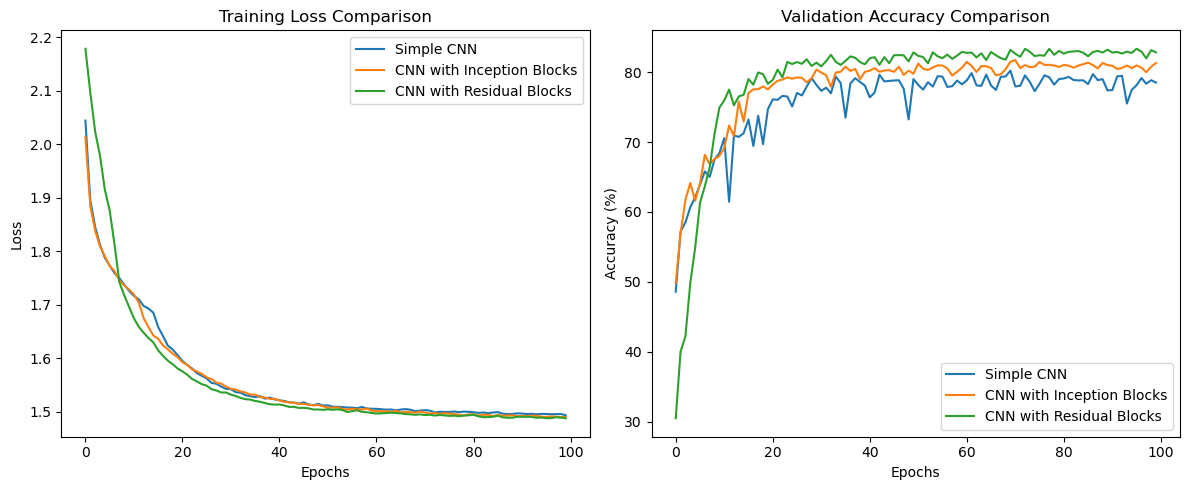

In [24]:
# Function to plot the training losses and validation accuracies for each model
def plot_results(results):
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    for model_name, (train_losses, _) in results.items():
        plt.plot(train_losses, label=model_name)  # Plot training losses for each model
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    for model_name, (_, val_accuracies) in results.items():
        plt.plot(val_accuracies, label=model_name)  # Plot validation accuracies for each model
    plt.title('Validation Accuracy Comparison')  # Set the title for the validation accuracy plot
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_results(results)

## **Evaluate the algorithm and report results**

**Simple CNN**: 70.70% accuracy

**Simple CNN with Inception Blocks**: 81.44% accuracy

**Simple CNN with Residual Blocks**: 83.32% accuracy

Simple CNN with Residual Blocks performed the best, showing a improvement over the other two models.